# Multiple Linear Regression Model #

### Time Series Regression Explaining Stock's Returns ###

In [312]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t

# Pretty Notation
from IPython.display import display, Math

In [313]:
# The Matricial Form of the OLS Linear Regresion Model

display(Math(r"Y = X\beta+\varepsilon"))

<IPython.core.display.Math object>

In [314]:
# Data S&P500

sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500.set_index('Date', inplace = True)
sp500.index = pd.to_datetime(sp500.index, dayfirst = True) # We use dayfirst = True if the dates format is dd/mm/yy
sp500.dropna(inplace = True)

# Cut the sample
sp500 = sp500.loc['2015-01-01':]

sp500

,sp_500
Date,
2015-02-23,2109.66
2015-02-24,2115.48
2015-02-25,2113.86
2015-02-26,2110.74
2015-02-27,2104.50
...,...
2025-02-14,6114.63
2025-02-18,6129.58
2025-02-19,6144.15


In [315]:
# Call the stock's data

data_stock = pd.read_csv(rf"..\stocks\AMZN.csv")
data_stock.set_index('Date', inplace = True)
data_stock.index = pd.to_datetime(data_stock.index)
data_stock.dropna(inplace = True)

# Cut the sample
data_stock = data_stock.loc['2015-01-01':]

data_stock

,Instrument,Open Price,High Price,Low Price,Close Price,Adjusted_close,Volume,Company Market Cap,Average Number of Shares Outstanding,Book Value per Share,...,Shares used to calculate Basic EPS - Total,T12M_Revenue,T12M_Net_Income,Announce_Date,Market_cap_calculado,Price_to_Sales,Price_to_Book,Price_to_Book_inverse,EPS_calculado,Price_to_Earnings
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,AMZN.OQ,15.6290,15.7375,15.3485,15.4260,15.4260,14932119.0,1.380724e+11,9.260000e+09,1.116199,...,9.260000e+09,8.524700e+10,-2.150000e+08,2014-10-23,1.428448e+11,1.675657,13.820120,0.072358,-0.023218,-664.394233
2015-01-05,AMZN.OQ,15.3505,15.4190,15.0425,15.1095,15.1095,21538739.0,1.355056e+11,9.260000e+09,1.116199,...,9.260000e+09,8.524700e+10,-2.150000e+08,2014-10-23,1.399140e+11,1.641277,13.536568,0.073874,-0.023218,-650.762651
2015-01-06,AMZN.OQ,15.1120,15.1270,14.6210,14.7645,14.7645,26109759.0,1.370541e+11,9.260000e+09,1.116199,...,9.260000e+09,8.524700e+10,-2.150000e+08,2014-10-23,1.367193e+11,1.603802,13.227484,0.075600,-0.023218,-635.903581
2015-01-07,AMZN.OQ,14.8750,15.0640,14.7670,14.9210,14.9210,31914019.0,1.363705e+11,9.260000e+09,1.116199,...,9.260000e+09,8.524700e+10,-2.150000e+08,2014-10-23,1.381685e+11,1.620801,13.367692,0.074807,-0.023218,-642.644000
2015-01-08,AMZN.OQ,15.0160,15.1570,14.8075,15.0230,15.0230,29392639.0,1.334318e+11,9.260000e+09,1.116199,...,9.260000e+09,8.524700e+10,-2.150000e+08,2014-10-23,1.391130e+11,1.631881,13.459073,0.074299,-0.023218,-647.037116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15,AMZN.OQ,187.5400,188.4100,184.5900,187.6900,187.6900,9804437.0,1.991009e+12,1.070800e+10,22.540229,...,1.044700e+10,6.043340e+11,4.441900e+10,2024-08-01,1.968868e+12,3.257914,8.326890,0.120093,4.251843,44.143214
2024-10-16,AMZN.OQ,187.0600,187.7700,185.6150,186.8900,186.8900,9654994.0,1.938636e+12,1.070800e+10,22.540229,...,1.044700e+10,6.043340e+11,4.441900e+10,2024-08-01,1.960476e+12,3.244027,8.291398,0.120607,4.251843,43.955060
2024-10-17,AMZN.OQ,188.1900,188.9400,186.0000,187.5300,187.5300,6480613.0,1.956164e+12,1.070800e+10,22.540229,...,1.044700e+10,6.043340e+11,4.441900e+10,2024-08-01,1.967190e+12,3.255137,8.319791,0.120195,4.251843,44.105583


In [316]:
# Create the Data we will need

data_regression = pd.DataFrame(index=data_stock.index)

# Now safely add new columns
data_regression['returns'] = data_stock['Adjusted_close'].pct_change(1)
data_regression['mkt_returns'] = sp500.pct_change(1)
data_regression['log_mktcap'] = np.log(data_stock['Company Market Cap'])
data_regression['anualized_volat'] = data_regression['returns'].rolling(window=252).std() * np.sqrt(252)
data_regression['ptb'] = data_stock['Price_to_Book']

# Drop nans
data_regression.dropna(inplace = True)

data_regression

,returns,mkt_returns,log_mktcap,anualized_volat,ptb
Date,,,,,
2016-01-04,-0.057554,-0.015304,26.391673,0.341059,24.034458
2016-01-05,-0.005024,0.002012,26.391916,0.340332,23.913718
2016-01-06,-0.001799,-0.013115,26.331750,0.339368,23.870704
2016-01-07,-0.039058,-0.023700,26.350800,0.341911,22.938364
2016-01-08,-0.001464,-0.010838,26.311558,0.341920,22.904783
...,...,...,...,...,...
2024-10-15,0.000800,-0.007609,28.319663,0.278492,8.326890
2024-10-16,-0.004262,0.004679,28.293006,0.277854,8.291398
2024-10-17,0.003424,-0.000171,28.302006,0.277690,8.319791


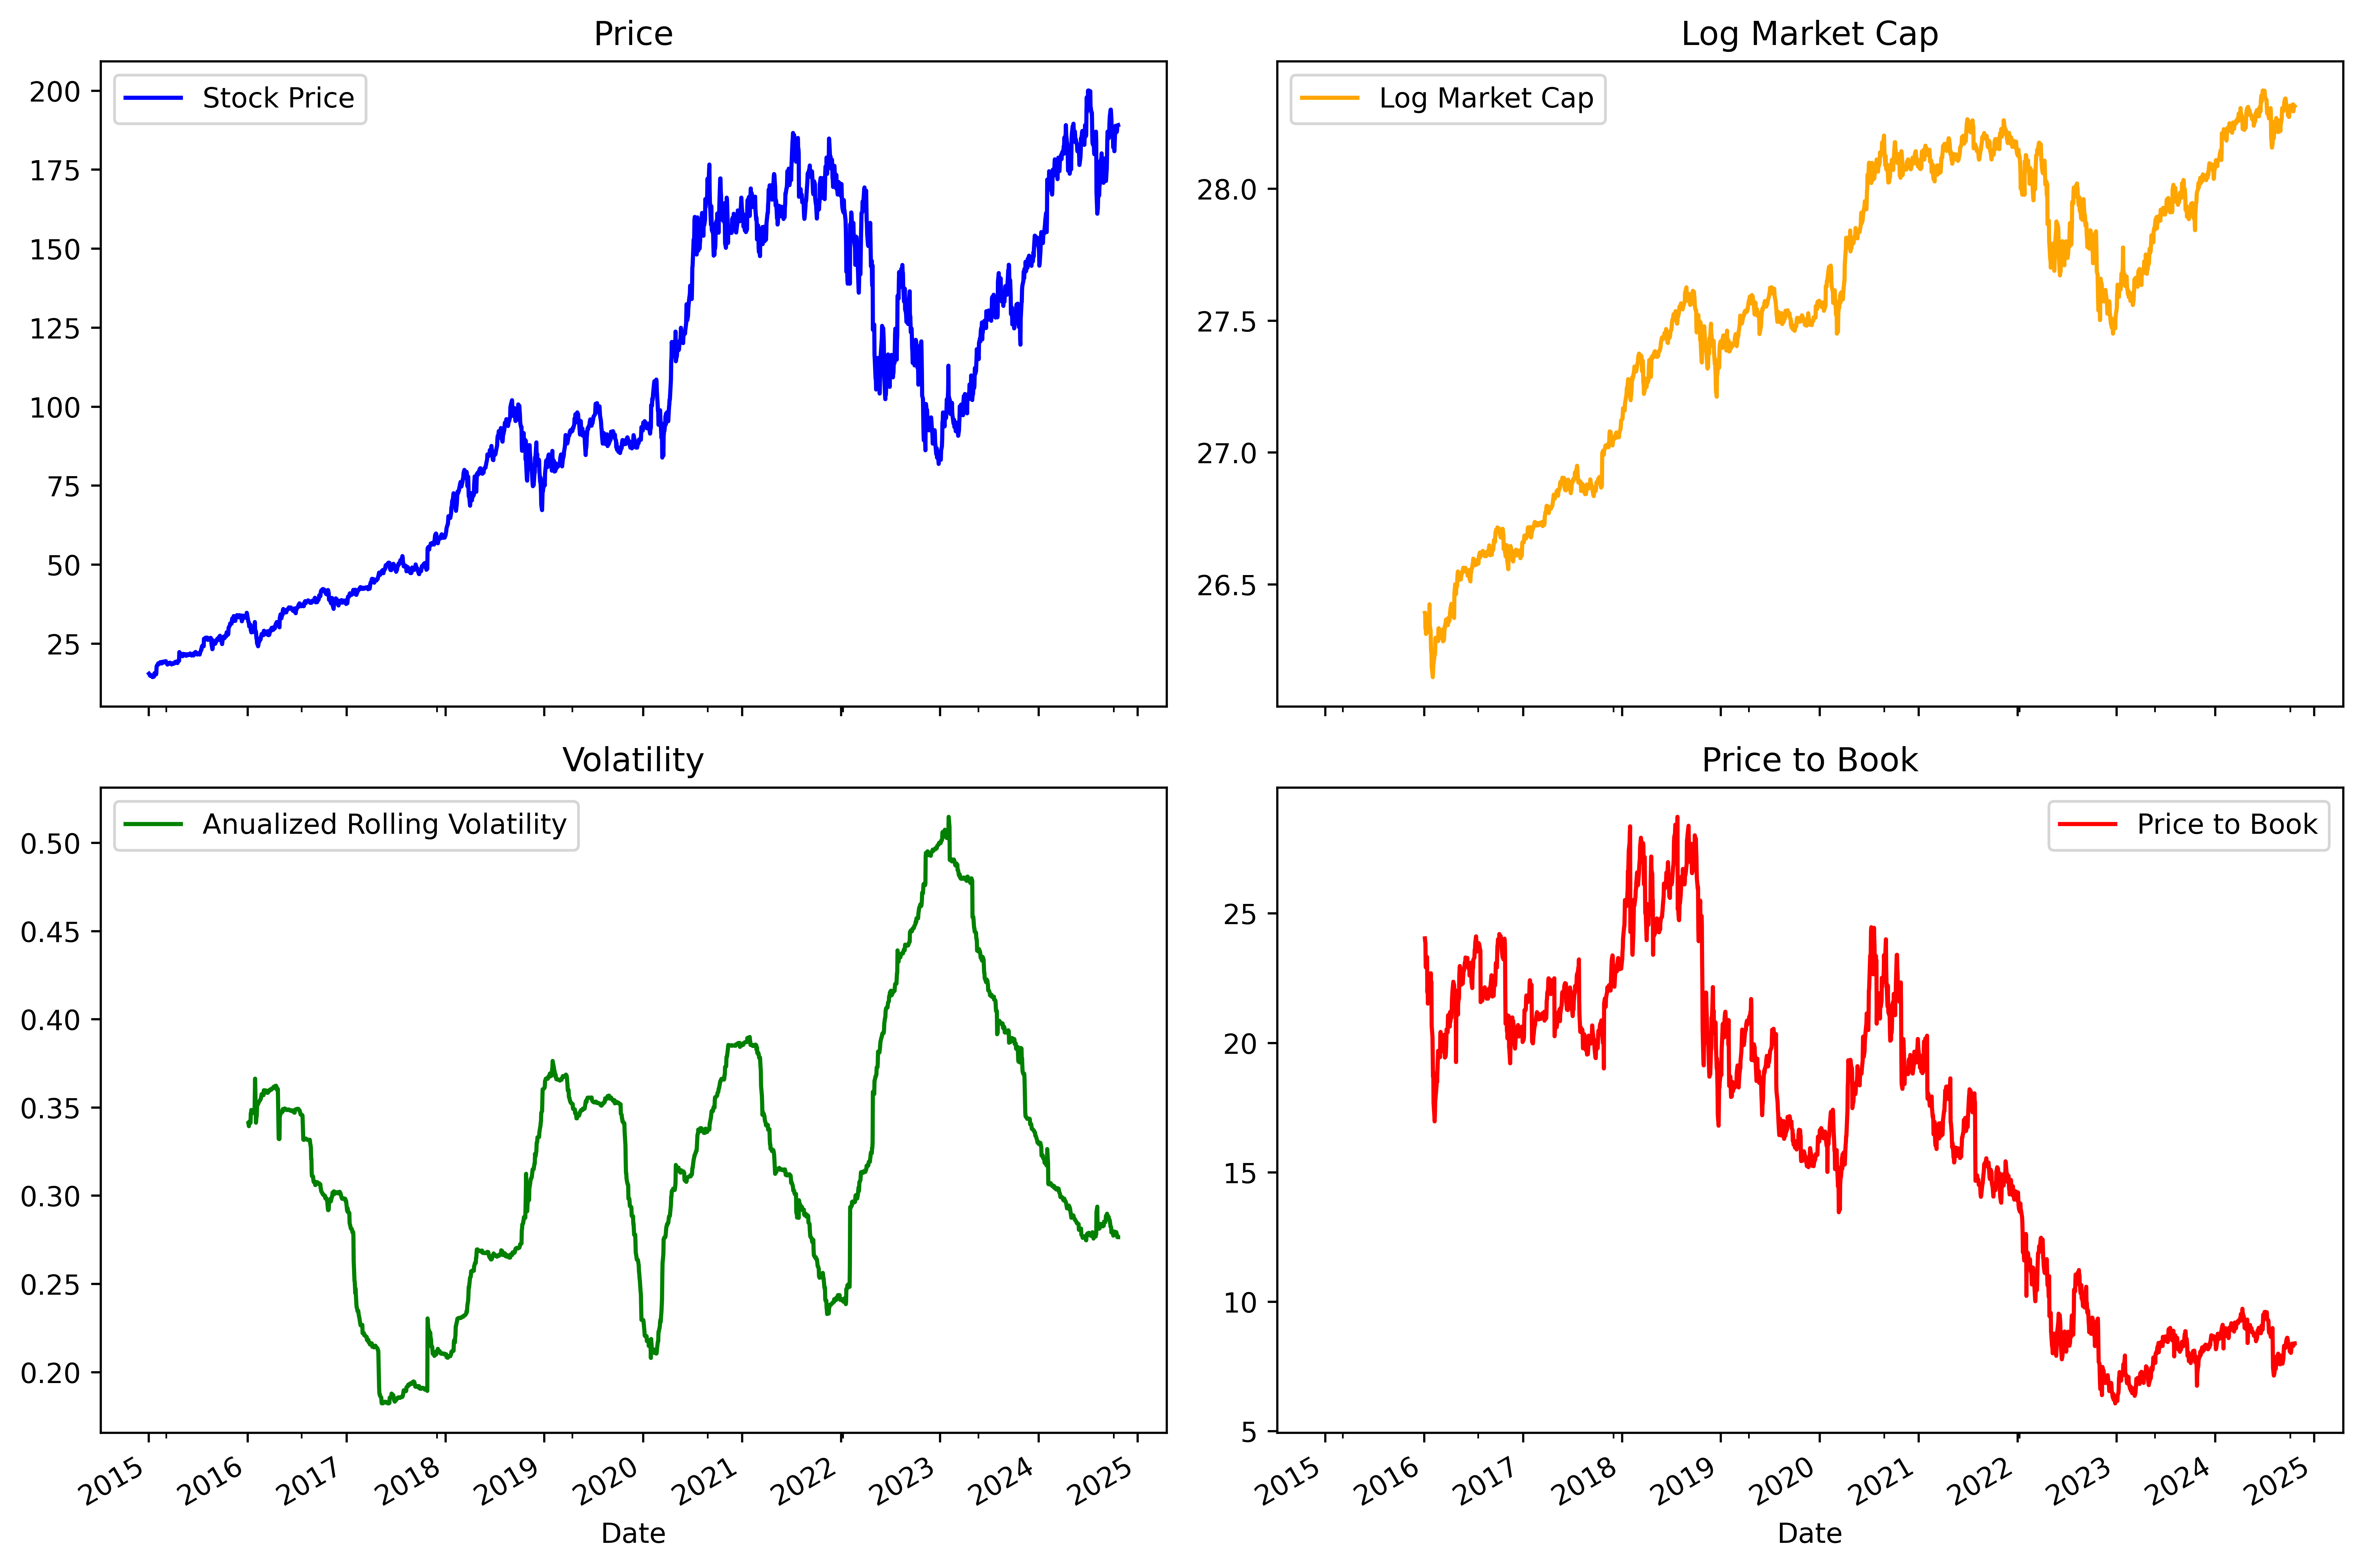

In [317]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=600, sharex=True)  # 2 filas, 2 columnas

# First Graph
data_stock['Adjusted_close'].plot(ax=axs[0, 0], color='blue', label='Stock Price')
axs[0, 0].set_title('Price')
axs[0, 0].legend()

# Second Graph
data_regression['log_mktcap'].plot(ax=axs[0, 1], color='orange', label='Log Market Cap')
axs[0, 1].set_title('Log Market Cap')
axs[0, 1].legend()

# Third Graph
data_regression['anualized_volat'].plot(ax=axs[1, 0], color='green', label='Anualized Rolling Volatility')
axs[1, 0].set_title('Volatility')
axs[1, 0].legend()

# Fourth
data_regression['ptb'].plot(ax=axs[1, 1], color='red', label='Price to Book')
axs[1, 1].set_title('Price to Book')
axs[1, 1].legend()

# Show
plt.tight_layout()
plt.show()

In [318]:
# Correlation Matrix

data_regression.corr()

,returns,mkt_returns,log_mktcap,anualized_volat,ptb
returns,1.000000,0.636627,0.006422,-0.010797,0.042797
mkt_returns,0.636627,1.000000,0.019290,0.012170,0.016401
log_mktcap,0.006422,0.019290,1.000000,0.218701,-0.563751
anualized_volat,-0.010797,0.012170,0.218701,1.000000,-0.523154
ptb,0.042797,0.016401,-0.563751,-0.523154,1.000000


In [319]:
# Why don't we try with changes

data_regression_diff = data_regression.copy()

data_regression_diff['log_mktcap'] = data_regression_diff['log_mktcap'].diff()
data_regression_diff['anualized_volat'] = data_regression_diff['anualized_volat'].pct_change()
data_regression_diff['ptb'] = data_regression_diff['ptb'].pct_change()

data_regression_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
data_regression_diff.dropna(inplace = True)

data_regression_diff

,returns,mkt_returns,log_mktcap,anualized_volat,ptb
Date,,,,,
2016-01-05,-0.005024,0.002012,0.000243,-0.002129,-0.005024
2016-01-06,-0.001799,-0.013115,-0.060167,-0.002834,-0.001799
2016-01-07,-0.039058,-0.023700,0.019050,0.007495,-0.039058
2016-01-08,-0.001464,-0.010838,-0.039242,0.000025,-0.001464
2016-01-11,0.017610,0.000853,0.007513,-0.000037,0.017610
...,...,...,...,...,...
2024-10-15,0.000800,-0.007609,0.003327,-0.002777,0.000800
2024-10-16,-0.004262,0.004679,-0.026657,-0.002294,-0.004262
2024-10-17,0.003424,-0.000171,0.009001,-0.000587,0.003424


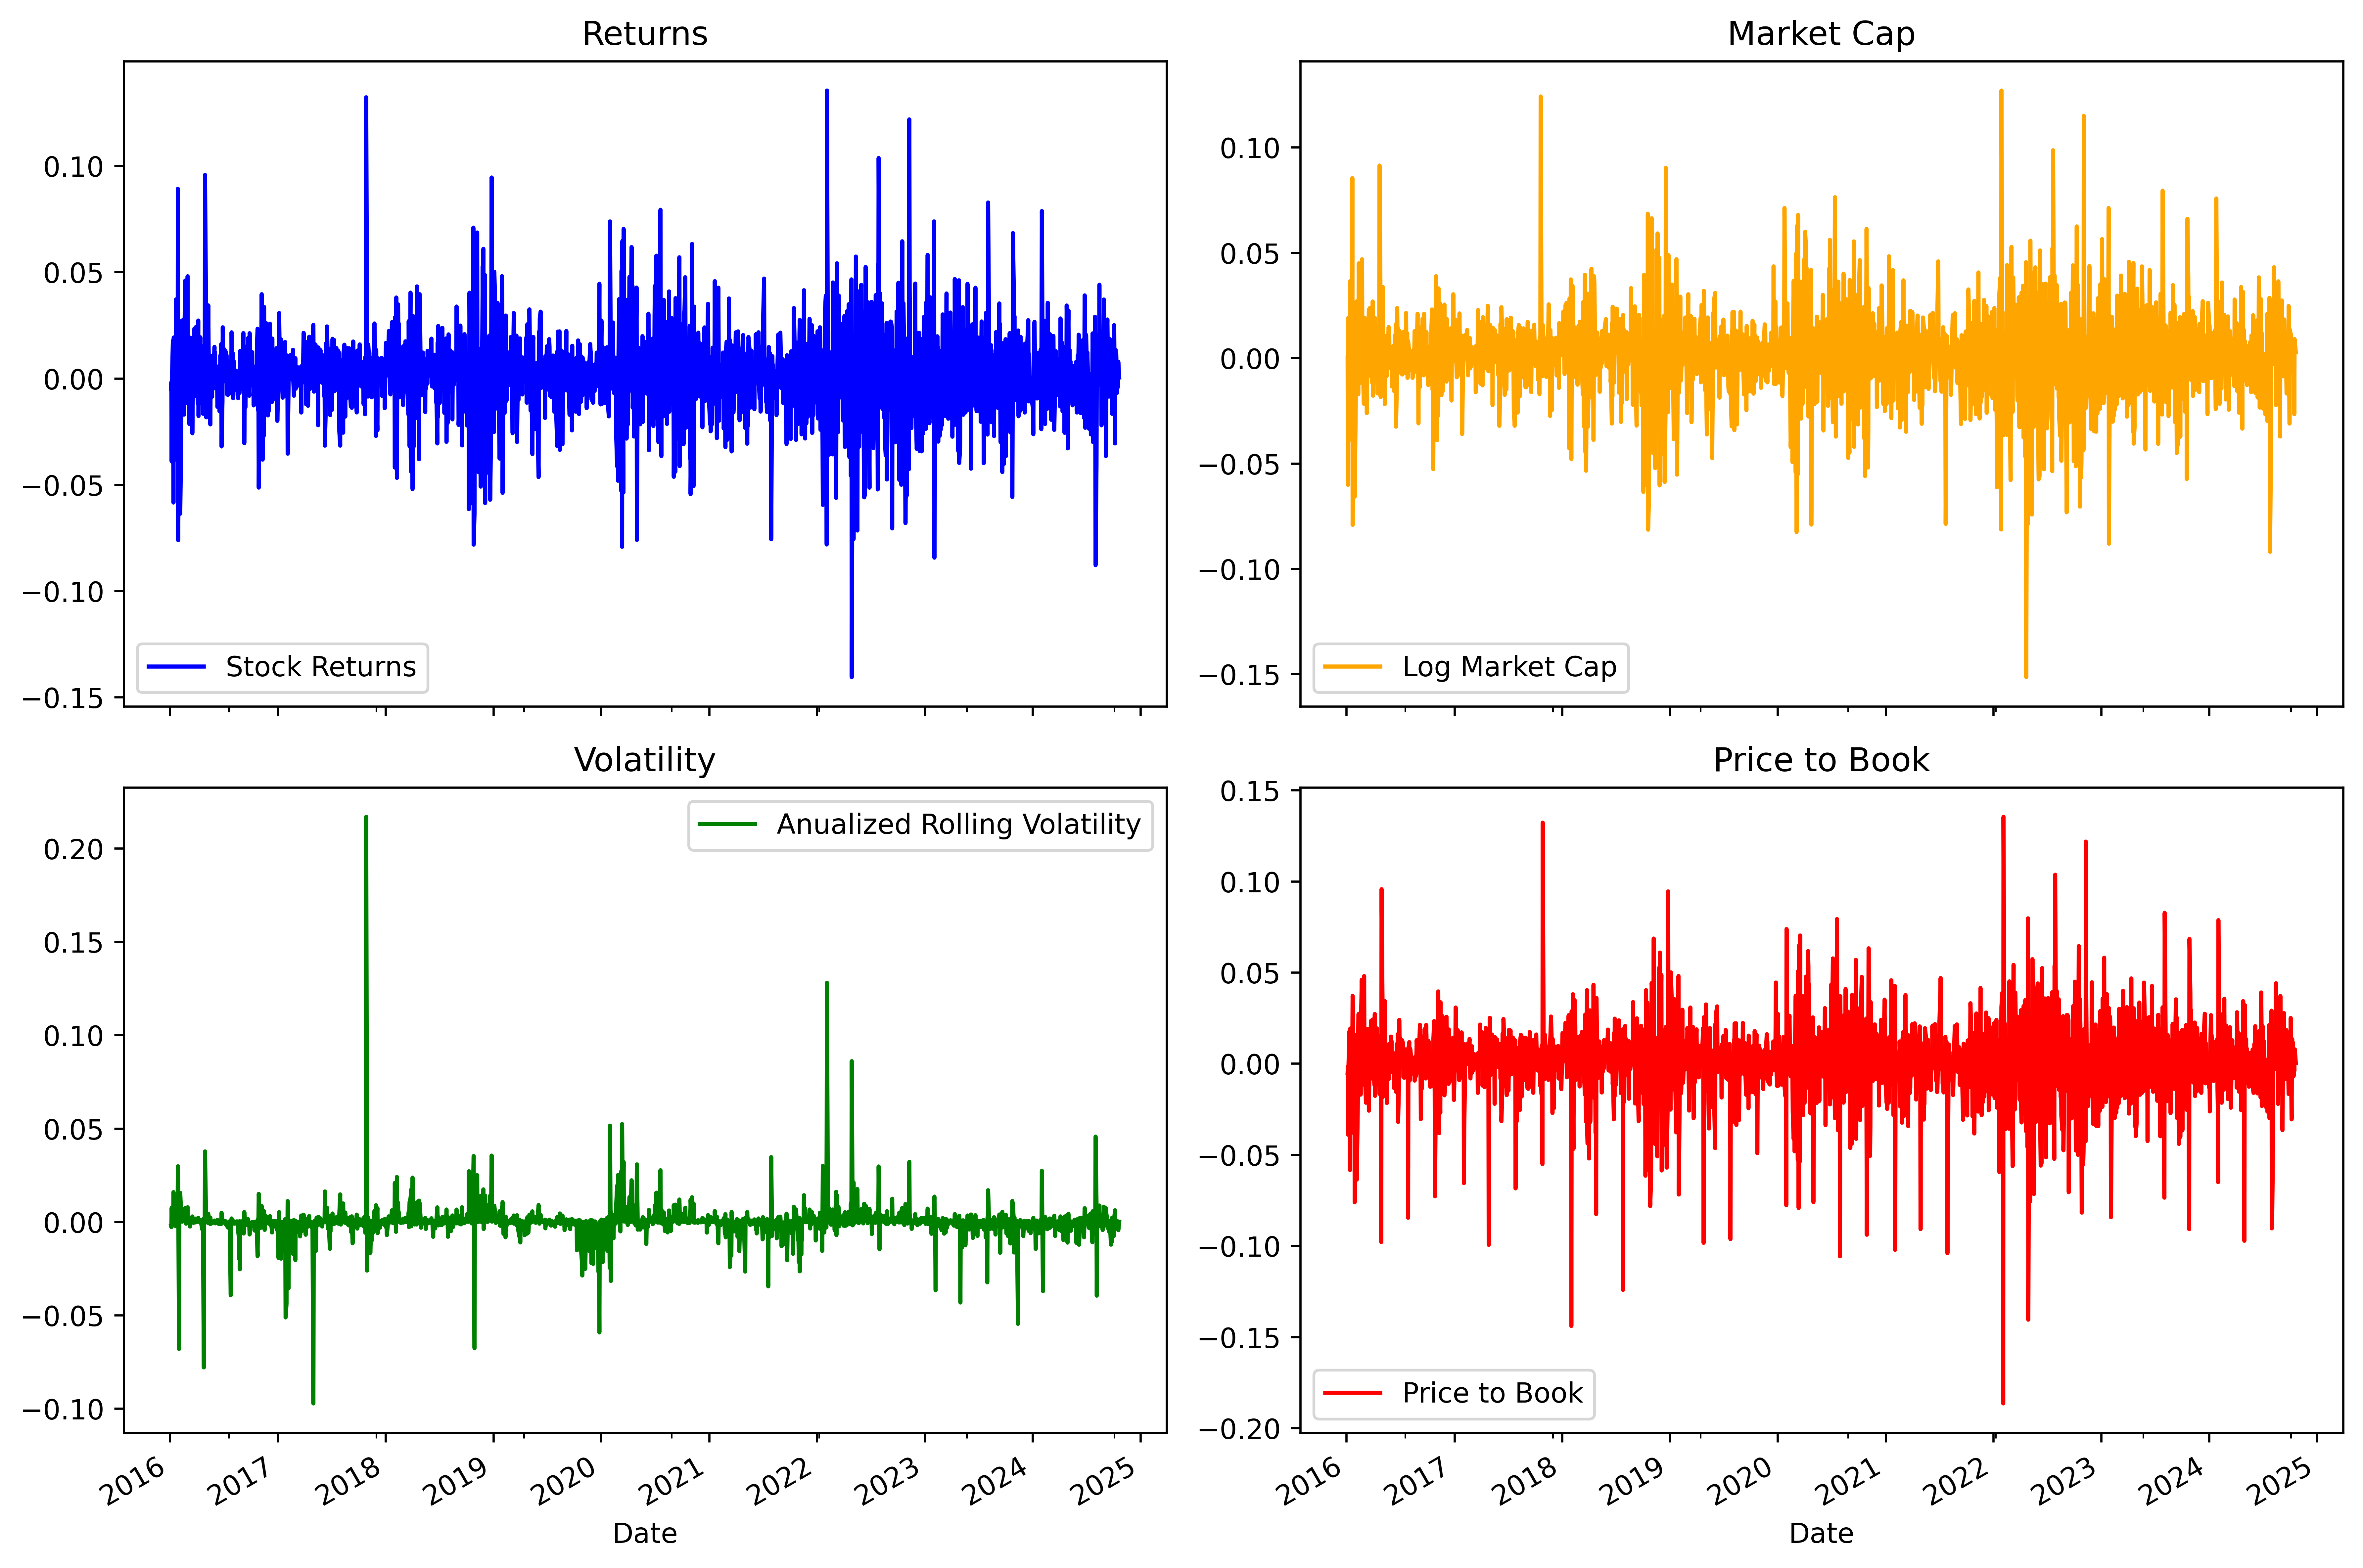

In [320]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=600, sharex=True)  # 2 filas, 2 columnas

# First Graph
data_regression_diff['returns'].plot(ax=axs[0, 0], color='blue', label='Stock Returns')
axs[0, 0].set_title('Returns')
axs[0, 0].legend()

# Second Graph
data_regression_diff['log_mktcap'].plot(ax=axs[0, 1], color='orange', label='Log Market Cap')
axs[0, 1].set_title('Market Cap')
axs[0, 1].legend()

# Third Graph
data_regression_diff['anualized_volat'].plot(ax=axs[1, 0], color='green', label='Anualized Rolling Volatility')
axs[1, 0].set_title('Volatility')
axs[1, 0].legend()

# Fourth
data_regression_diff['ptb'].plot(ax=axs[1, 1], color='red', label='Price to Book')
axs[1, 1].set_title('Price to Book')
axs[1, 1].legend()

# Show
plt.tight_layout()
plt.show()

In [321]:
# The Correlation Matrix

data_regression_diff.corr()

,returns,mkt_returns,log_mktcap,anualized_volat,ptb
returns,1.000000,0.636286,0.001612,0.061571,0.886930
mkt_returns,0.636286,1.000000,-0.017562,-0.071610,0.570631
log_mktcap,0.001612,-0.017562,1.000000,0.001166,-0.001075
anualized_volat,0.061571,-0.071610,0.001166,1.000000,0.033257
ptb,0.886930,0.570631,-0.001075,0.033257,1.000000


In [323]:
filtered_data = data_regression_diff[(np.abs(data_regression_diff - data_regression_diff.mean()) <= 3 * data_regression_diff.std())]

filtered_data.dropna(inplace = True)

filtered_data

,returns,mkt_returns,log_mktcap,anualized_volat,ptb
Date,,,,,
2016-01-05,-0.005024,0.002012,0.000243,-0.002129,-0.005024
2016-01-06,-0.001799,-0.013115,-0.060167,-0.002834,-0.001799
2016-01-07,-0.039058,-0.023700,0.019050,0.007495,-0.039058
2016-01-08,-0.001464,-0.010838,-0.039242,0.000025,-0.001464
2016-01-11,0.017610,0.000853,0.007513,-0.000037,0.017610
...,...,...,...,...,...
2024-10-15,0.000800,-0.007609,0.003327,-0.002777,0.000800
2024-10-16,-0.004262,0.004679,-0.026657,-0.002294,-0.004262
2024-10-17,0.003424,-0.000171,0.009001,-0.000587,0.003424


In [324]:
# The Correlation Matrix

filtered_data.corr()

,returns,mkt_returns,log_mktcap,anualized_volat,ptb
returns,1.000000,0.665356,0.000147,-0.055309,0.973601
mkt_returns,0.665356,1.000000,-0.015974,-0.100294,0.650756
log_mktcap,0.000147,-0.015974,1.000000,0.005119,0.000491
anualized_volat,-0.055309,-0.100294,0.005119,1.000000,-0.048718
ptb,0.973601,0.650756,0.000491,-0.048718,1.000000


In [326]:
# Create the Y Vector

Y_Vector = filtered_data["returns"]

Y_Vector

Date
2016-01-05   -0.005024
2016-01-06   -0.001799
2016-01-07   -0.039058
2016-01-08   -0.001464
2016-01-11    0.017610
                ...   
2024-10-15    0.000800
2024-10-16   -0.004262
2024-10-17    0.003424
2024-10-18    0.007785
2024-10-21    0.000423
Name: returns, Length: 2087, dtype: float64

In [327]:
# Create the Information Matrix
# Remember to add a constant

filtered_data['constant'] = 1
filtered_data['squared_volat'] = filtered_data['anualized_volat'].mul(filtered_data['anualized_volat'])

Information_Matrix = filtered_data.copy().drop('returns', axis=1)

Information_Matrix

,mkt_returns,log_mktcap,anualized_volat,ptb,constant,squared_volat
Date,,,,,,
2016-01-05,0.002012,0.000243,-0.002129,-0.005024,1,4.533304e-06
2016-01-06,-0.013115,-0.060167,-0.002834,-0.001799,1,8.032826e-06
2016-01-07,-0.023700,0.019050,0.007495,-0.039058,1,5.617425e-05
2016-01-08,-0.010838,-0.039242,0.000025,-0.001464,1,6.179545e-10
2016-01-11,0.000853,0.007513,-0.000037,0.017610,1,1.354987e-09
...,...,...,...,...,...,...
2024-10-15,-0.007609,0.003327,-0.002777,0.000800,1,7.714083e-06
2024-10-16,0.004679,-0.026657,-0.002294,-0.004262,1,5.262192e-06
2024-10-17,-0.000171,0.009001,-0.000587,0.003424,1,3.449467e-07


In [328]:
# For estimating the coefficients with the OLS we need to assess the non-perfect collinearity condition with the matrix rank

Rank = np.linalg.matrix_rank(Information_Matrix)

# Since we are estimating four betas, the rank must be the number of columns in the Information Matrix

if Rank == 6:
    print(f"Matrix Rank is {Rank}; there is no evidence of Perfect Multicollinearity.")
else:
    print(f"Matrix Rank is {Rank}; there is evidence of Perfect Multicollinearity between two or more variables.")

Matrix Rank is 6; there is no evidence of Perfect Multicollinearity.


In [329]:
# The beta calculation in the Matrix Form

display(Math(r"\beta=(X^⊤X)^{-1}(X^⊤Y)"))

# The vector of betas is a kx1 vector containing the coefficients of the regression model, where k is the number of parameters to estimate

<IPython.core.display.Math object>

In [330]:
# Transpose of the Information Matrix

Information_Matrix_T = Information_Matrix.transpose()

Information_Matrix_T

Date,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-19,...,2024-10-08,2024-10-09,2024-10-10,2024-10-11,2024-10-14,2024-10-15,2024-10-16,2024-10-17,2024-10-18,2024-10-21
mkt_returns,0.002012,-0.013115,-0.023700,-1.083841e-02,8.532645e-04,0.007803,-0.024965,1.669594e-02,-0.021599,5.318215e-04,...,9.689358e-03,7.113385e-03,-2.070082e-03,0.006052,7.707613e-03,-0.007609,0.004679,-1.711605e-04,0.003972,-1.822779e-03
log_mktcap,0.000243,-0.060167,0.019050,-3.924230e-02,7.513183e-03,-0.000301,0.005668,3.647322e-02,0.000251,7.881288e-03,...,7.995097e-04,-4.271457e-03,3.418624e-03,0.007755,4.232133e-04,0.003327,-0.026657,9.000573e-03,0.007750,2.976984e-03
anualized_volat,-0.002129,-0.002834,0.007495,2.485869e-05,-3.681015e-05,-0.001999,0.015860,8.379578e-04,0.004652,-3.477544e-04,...,-7.891169e-04,8.949705e-04,-1.394696e-04,-0.001115,4.157272e-04,-0.002777,-0.002294,-5.873217e-04,-0.004521,9.421876e-06
ptb,-0.005024,-0.001799,-0.039058,-1.463960e-03,1.760975e-02,0.000243,-0.058392,1.923308e-02,-0.038482,7.541478e-03,...,1.061947e-02,1.340849e-02,7.992655e-03,0.011626,-6.778943e-03,0.000800,-0.004262,3.424474e-03,0.007785,4.233028e-04
constant,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
squared_volat,0.000005,0.000008,0.000056,6.179545e-10,1.354987e-09,0.000004,0.000252,7.021733e-07,0.000022,1.209331e-07,...,6.227054e-07,8.009722e-07,1.945178e-08,0.000001,1.728291e-07,0.000008,0.000005,3.449467e-07,0.000020,8.877174e-11


In [331]:
# Now we have to calculate the (X^⊤X)^{-1}, first the square of the Information Matrix

Information_Matrix_Square = Information_Matrix_T.dot(Information_Matrix)

# We could also use the command Information_Matrix_T @ Information_Matrix

Information_Matrix_Square

,mkt_returns,log_mktcap,anualized_volat,ptb,constant,squared_volat
mkt_returns,0.173503,-0.003940,-0.009095,0.216333,1.567321,-0.000016
log_mktcap,-0.003940,0.642027,0.000165,0.001801,1.819580,0.000034
anualized_volat,-0.009095,0.000165,0.042120,-0.008564,-0.771971,-0.000268
ptb,0.216333,0.001801,-0.008564,0.635111,1.706912,-0.000046
constant,1.567321,1.819580,-0.771971,1.706912,2087.000000,0.042120
squared_volat,-0.000016,0.000034,-0.000268,-0.000046,0.042120,0.000010


In [332]:
# The reason we needed to know the rank of the information matrix is because, only full rank matrix can be invertible
# The we can calculate the Matrix Determinant, if it is different from zero, we can calculate the OLS coefficients

Information_Matrix_Square_Determinant = np.linalg.det(Information_Matrix_Square)

if Information_Matrix_Square_Determinant != 0:
    print(f"The Determinant of the Squared Information Matrix is {Information_Matrix_Square_Determinant} and different from zero")
else:
    print("Matrix NOT invertible")

The Determinant of the Squared Information Matrix is 2.781987361953638e-05 and different from zero


In [333]:
# Now we have to obtain the Inverse Matrix

X_Variance_Matrix_Inverse = np.linalg.inv(Information_Matrix_Square)

X_Variance_Matrix_Inverse

array([[ 1.01937124e+01,  8.39780859e-02,  1.85434883e+00,
        -3.42698742e+00, -5.67936305e-03,  7.13269767e+01],
       [ 8.39780859e-02,  1.56216219e+00, -1.95021839e-02,
        -2.95063143e-02, -1.40909714e-03,  4.73928708e-02],
       [ 1.85434883e+00, -1.95021839e-02,  2.89050978e+01,
        -1.69414699e-01, -6.10007276e-03,  7.70731378e+02],
       [-3.42698742e+00, -2.95063143e-02, -1.69414699e-01,
         2.73900875e+00,  2.69049997e-04,  1.36137104e+00],
       [-5.67936305e-03, -1.40909714e-03, -6.10007276e-03,
         2.69049997e-04,  5.28499891e-04, -2.29541049e+00],
       [ 7.13269767e+01,  4.73928708e-02,  7.70731378e+02,
         1.36137104e+00, -2.29541049e+00,  1.25150188e+05]])

In [334]:
# Now we have to obtain (X^⊤Y)

Y_Covariance_X = Information_Matrix_T.dot(Y_Vector)

Y_Covariance_X

mkt_returns        0.218566
log_mktcap         0.002000
anualized_volat   -0.009694
ptb                0.610490
constant           2.188514
squared_volat     -0.000025
dtype: float64

In [335]:
# Now we can calculate the Betas

Beta = X_Variance_Matrix_Inverse.dot(Y_Covariance_X)

print(Beta)

[ 1.03849960e-01  5.70462480e-04 -1.08963141e-02  9.25251475e-01
  1.92972181e-04  8.12988779e-01]


In [336]:
# Now we can obtain the fitted values

Y_Hat = Information_Matrix.dot(Beta)

Y_Hat

Date
2016-01-05   -0.004219
2016-01-06   -0.002830
2016-01-07   -0.038432
2016-01-08   -0.002310
2016-01-11    0.016580
                ...   
2024-10-15    0.000181
2024-10-16   -0.003251
2024-10-17    0.003356
2024-10-18    0.007879
2024-10-21    0.000397
Length: 2087, dtype: float64

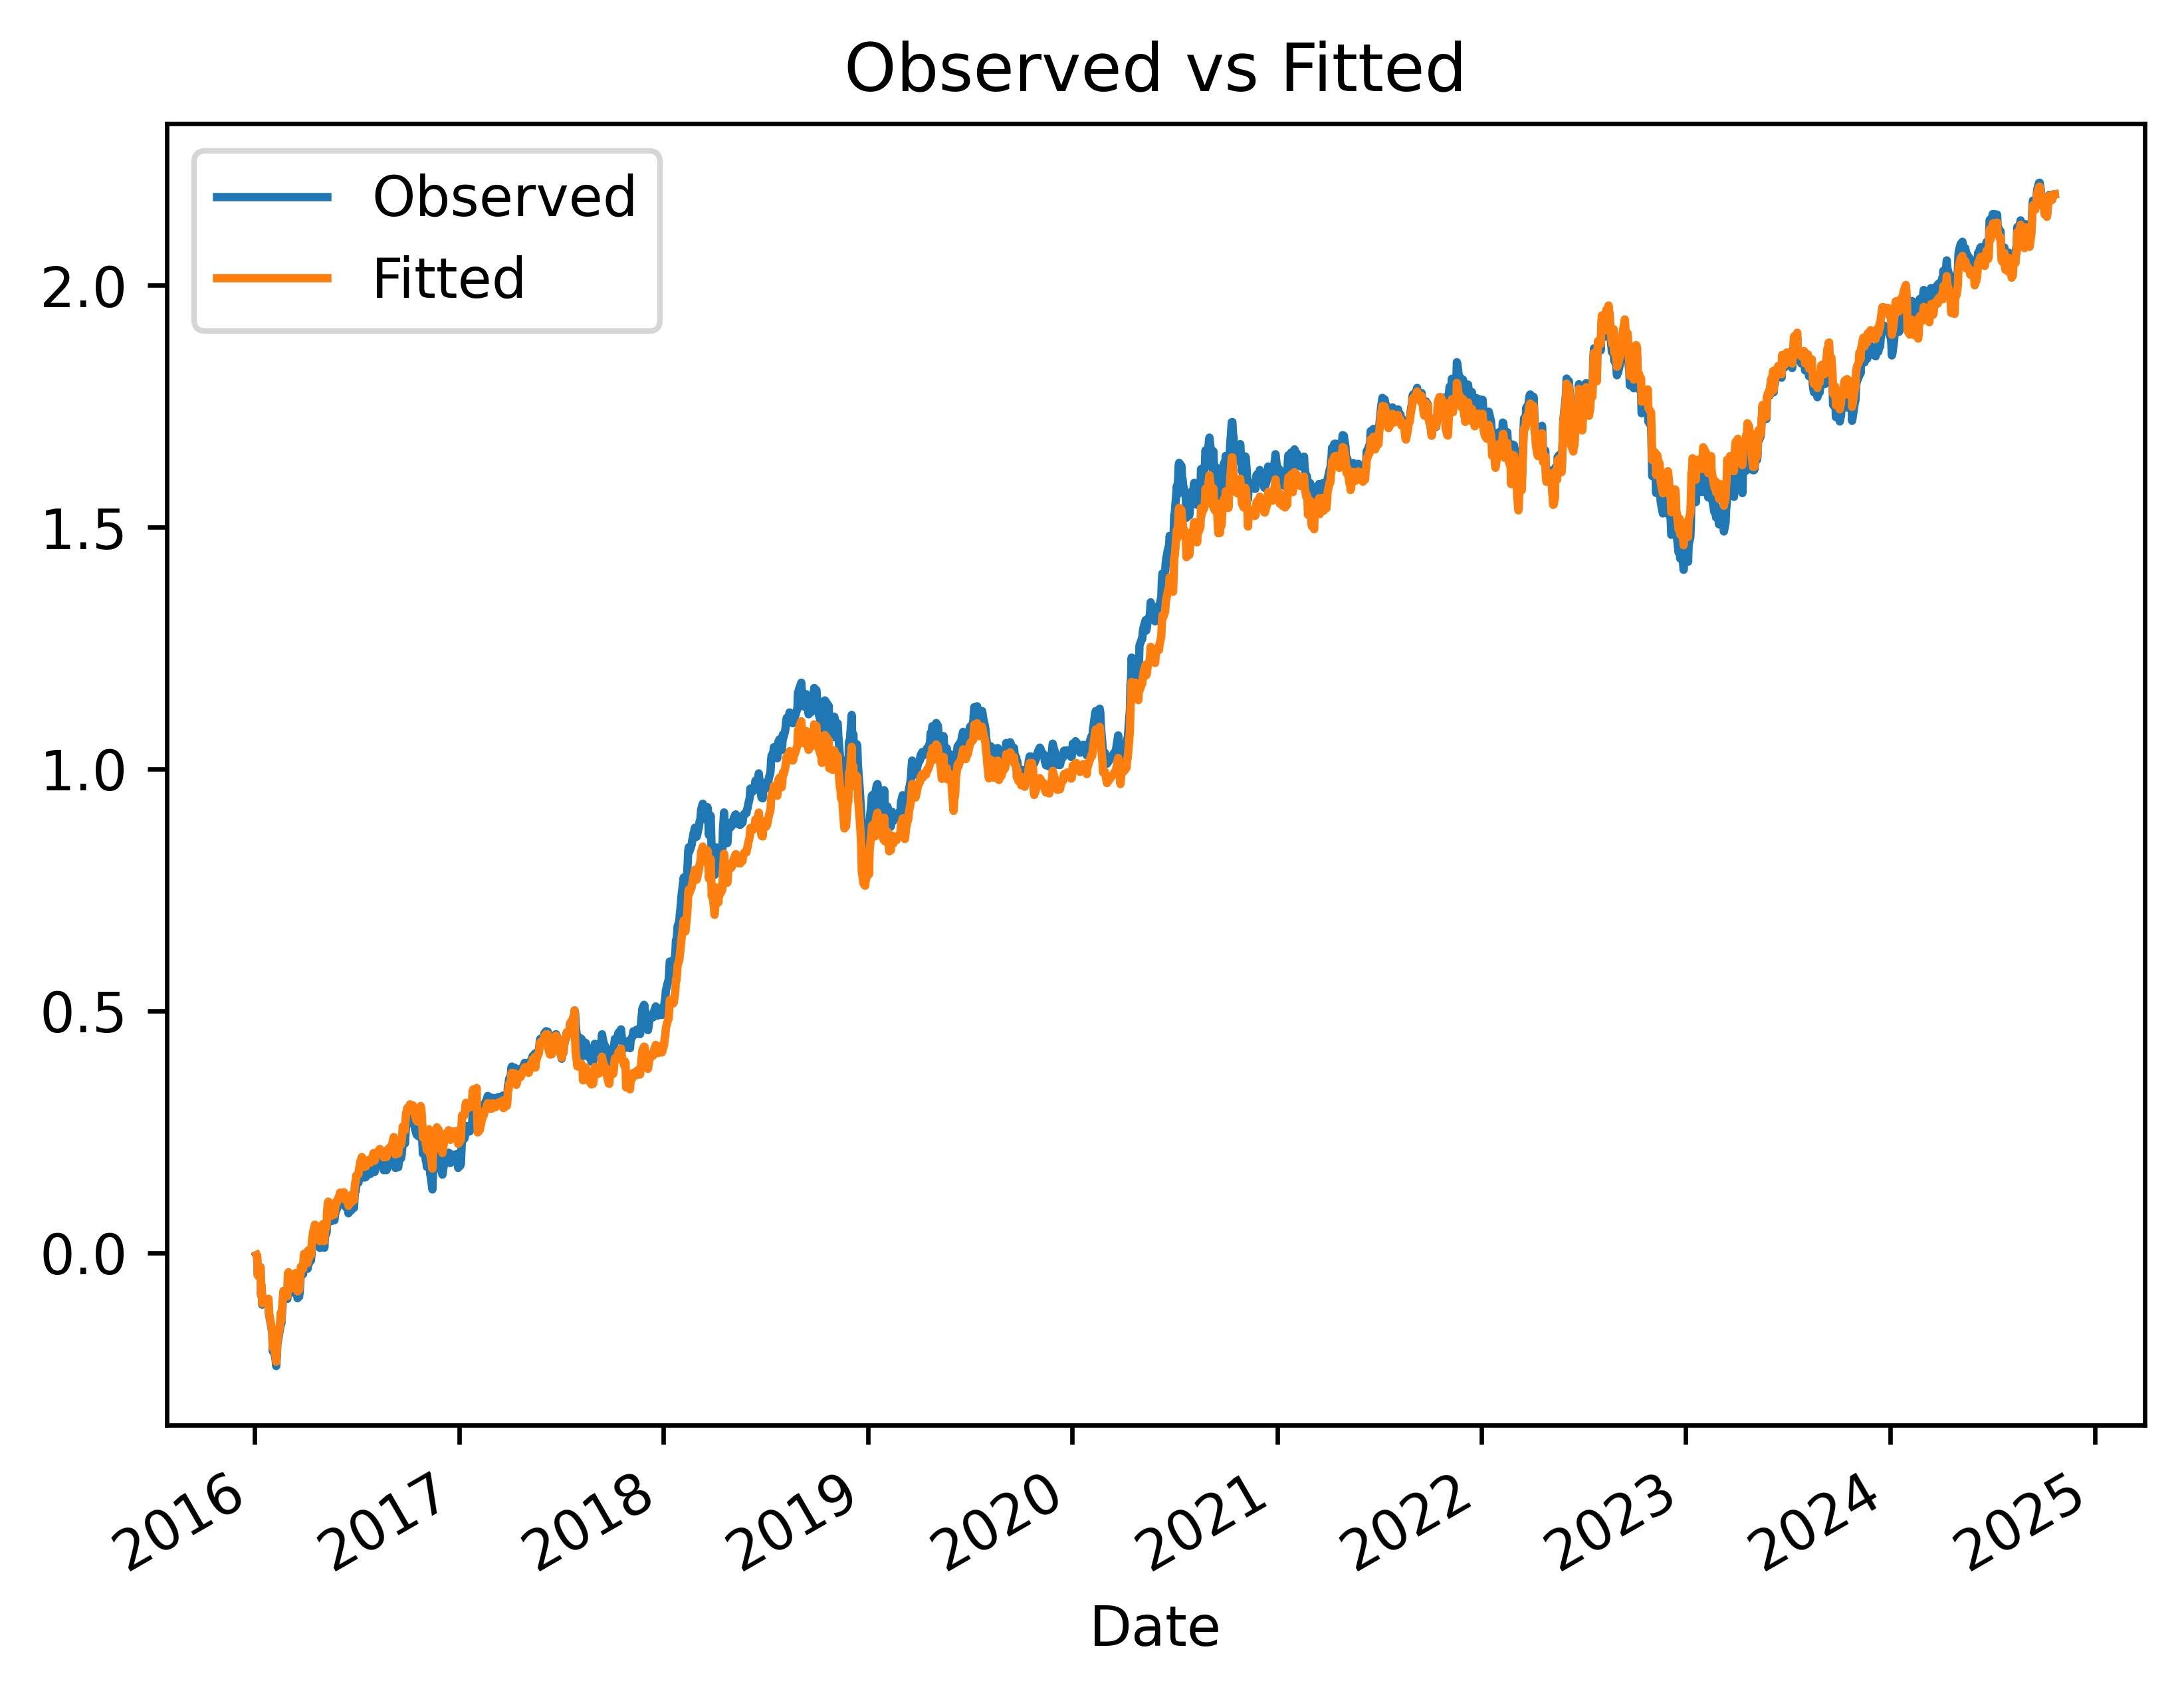

In [337]:
fig, ax1 = plt.subplots(dpi = 600)

filtered_data['expected_returns'] = Y_Hat

filtered_data['returns'].cumsum().plot(label = 'Observed')
filtered_data['expected_returns'].cumsum().plot(label = 'Fitted')
plt.legend()
plt.title('Observed vs Fitted')

plt.show()

In [338]:
# We can obtain the Hat Matrix which is a matrix used to transform the real values into the fitted values

Some_Matrix = Information_Matrix.dot(X_Variance_Matrix_Inverse)
Hat_Matrix = Some_Matrix.to_numpy() @ Information_Matrix_T.to_numpy()

Hat_Matrix

array([[ 7.87827337e-04,  3.64159302e-04, -1.48179381e-05, ...,
         4.72344166e-04,  6.73069581e-04,  4.55075750e-04],
       [ 3.64159302e-04,  8.54513222e-03, -4.56981058e-04, ...,
         4.87045322e-05,  8.57054966e-05,  6.76762715e-04],
       [-1.48179381e-05, -4.56981058e-04,  6.37503476e-03, ...,
         4.96287607e-04, -7.19849852e-04,  6.94263814e-04],
       ...,
       [ 4.72344166e-04,  4.87045322e-05,  4.96287607e-04, ...,
         6.84342122e-04,  6.71362031e-04,  5.97378544e-04],
       [ 6.73069581e-04,  8.57054966e-05, -7.19849852e-04, ...,
         6.71362031e-04,  1.09675022e-03,  5.09359283e-04],
       [ 4.55075750e-04,  6.76762715e-04,  6.94263814e-04, ...,
         5.97378544e-04,  5.09359283e-04,  5.93370347e-04]])

In [339]:
print(Information_Matrix.shape)
print(X_Variance_Matrix_Inverse.shape)
print(Some_Matrix.shape)
print(Information_Matrix_T.shape)

(2087, 6)
(6, 6)
(2087, 6)
(6, 2087)


In [340]:
# Let us check if this is true

Y_Hat_2 = Hat_Matrix.dot(Y_Vector)

Y_Hat_2

array([-0.00421915, -0.00283023, -0.03843185, ...,  0.00335551,
        0.0078792 ,  0.00039693])

In [341]:
# Hat Matrix is Symmetric and Idempotent

Hat_Matrix_Square = (Hat_Matrix.transpose()).dot(Hat_Matrix)

if Hat_Matrix.all() == Hat_Matrix_Square.all():
    print("It is indeed idempotent")
else:
    print("Wrong!")

It is indeed idempotent


In [342]:
# We can calculate the residuals using the Hat Matrix

Identity_Matrix = np.identity(len(Y_Vector))
Residuals_Vector = (Identity_Matrix - Hat_Matrix).dot(Y_Vector)

print(f"The Residuals Mean is: {Residuals_Vector.mean()}")
print(f"The Residuals Variance is: {Residuals_Vector.var()}")

The Residuals Mean is: 3.1253283515442234e-19
The Residuals Variance is: 1.4872934176815769e-05


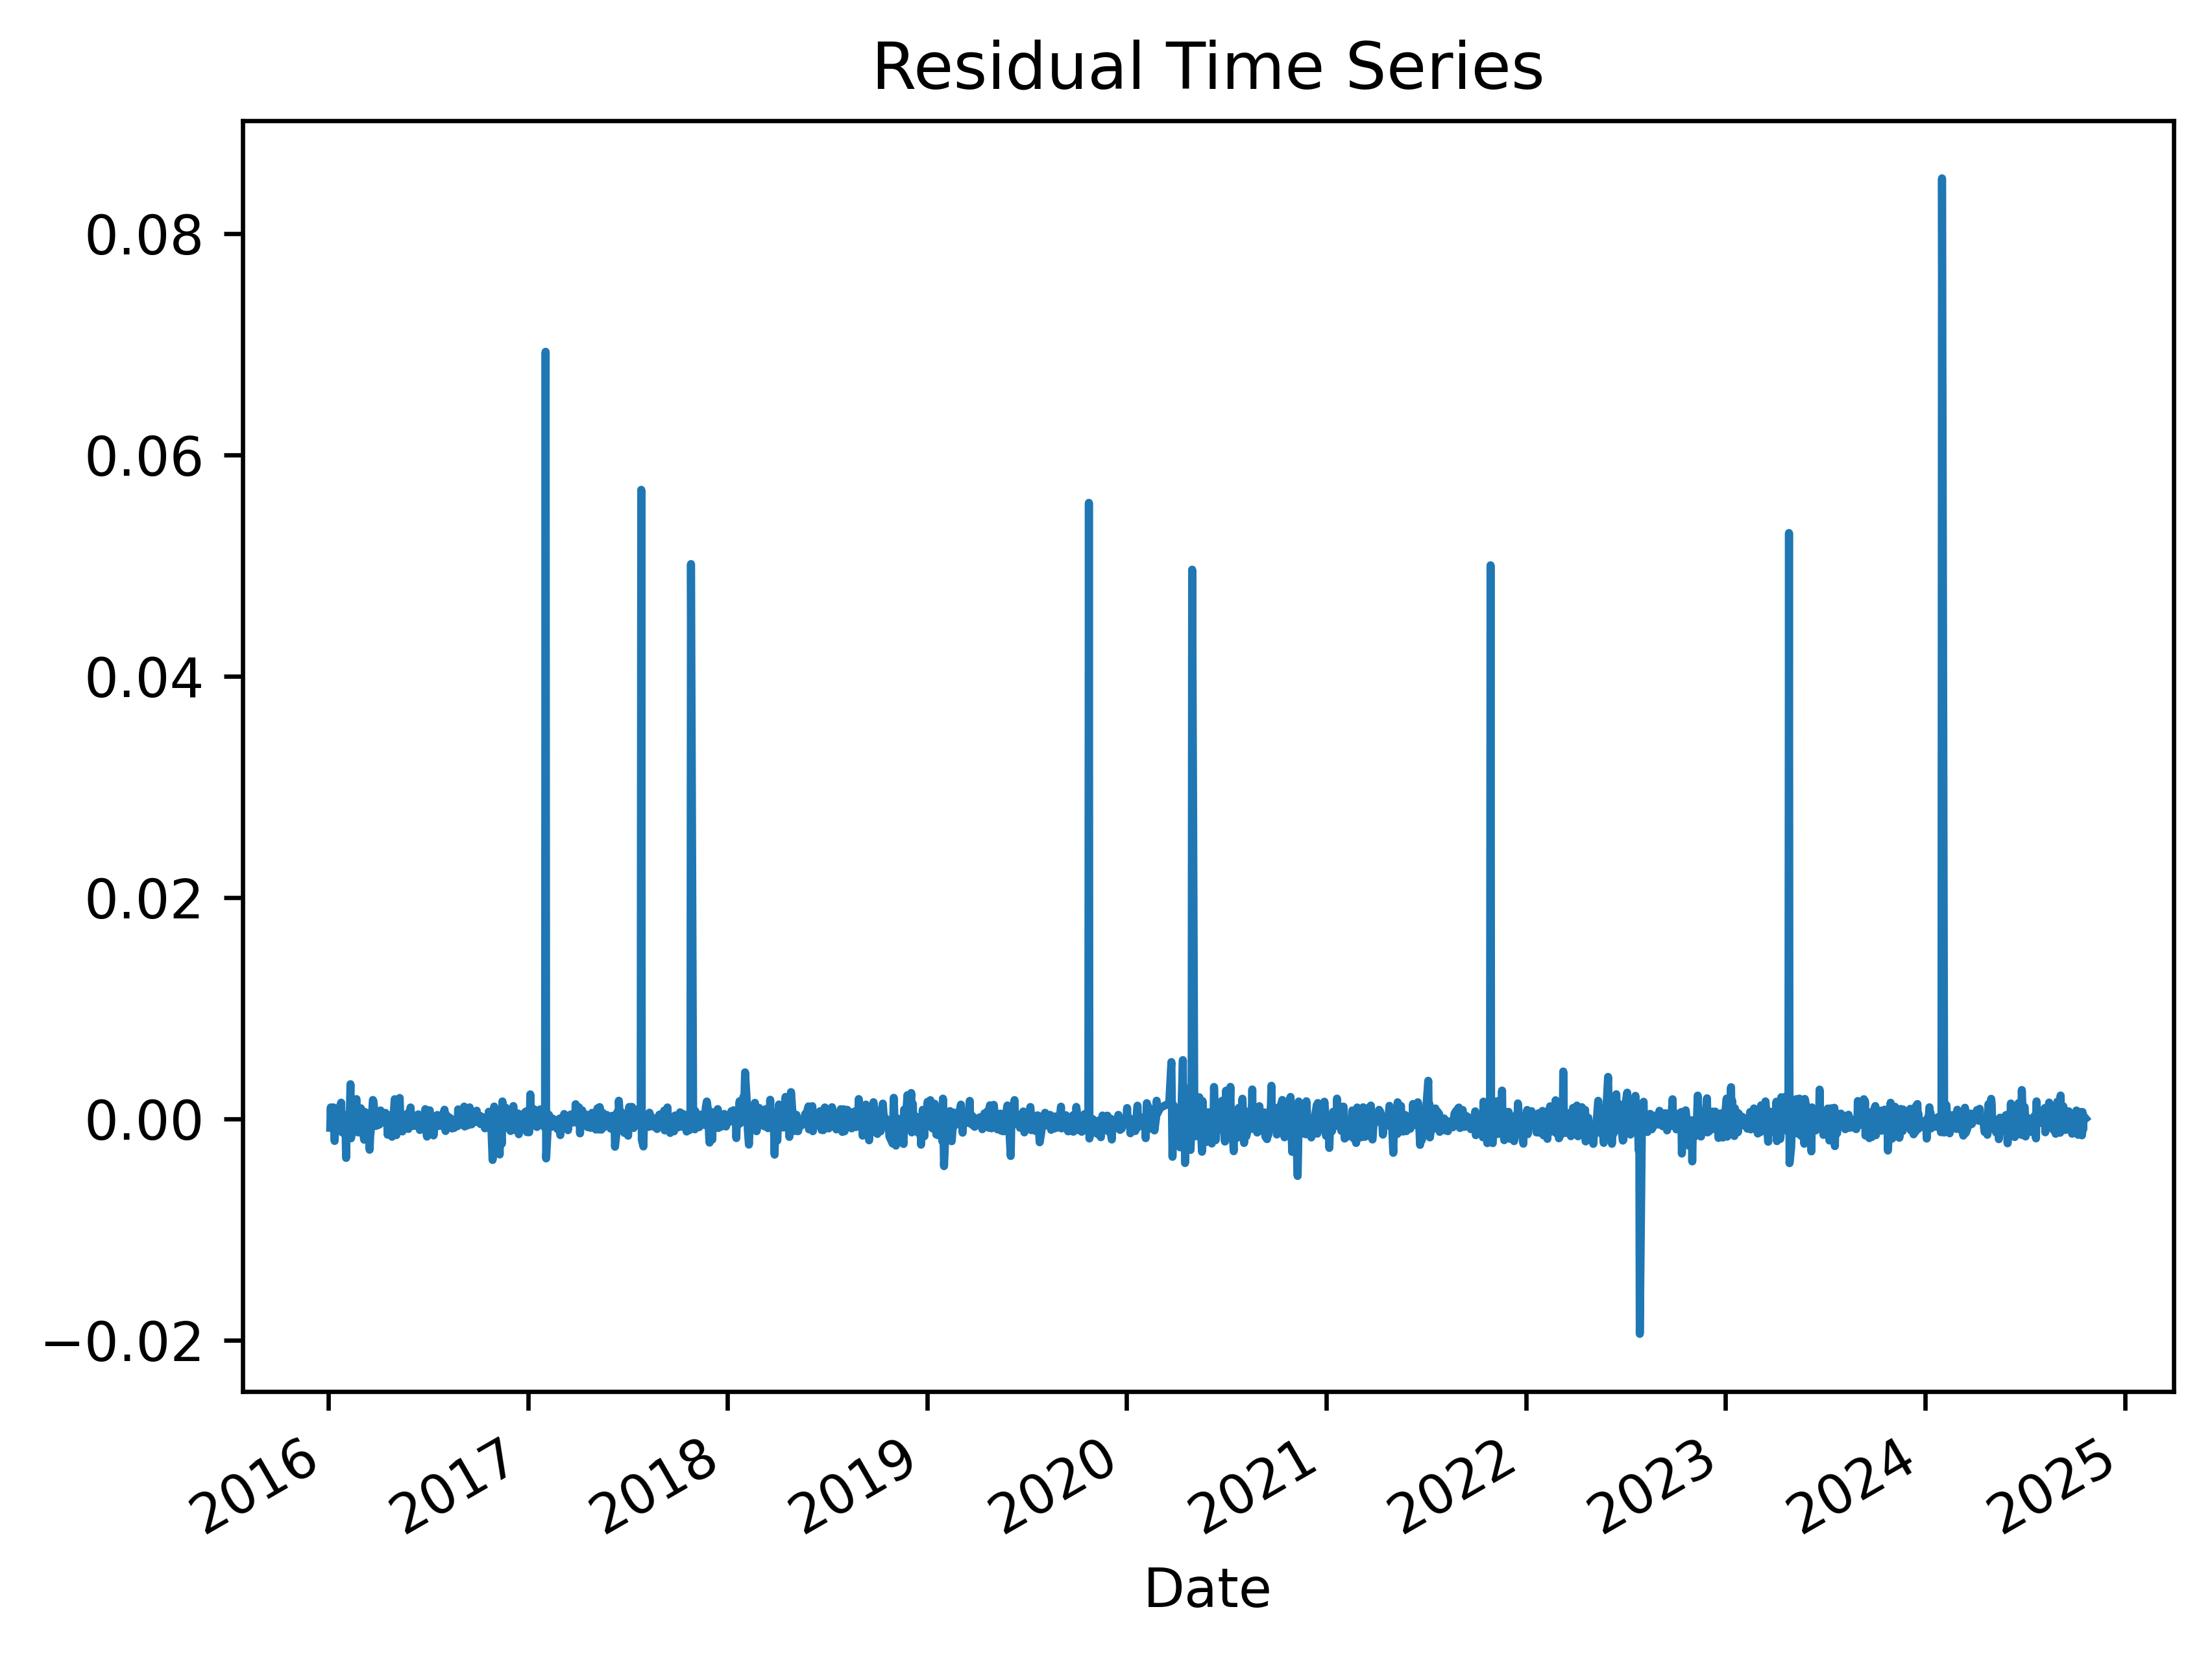

In [343]:
filtered_data['residuals'] = Residuals_Vector

fig, ax1 = plt.subplots(dpi = 600)
filtered_data['residuals'].plot()
plt.title('Residual Time Series')
plt.show()

In [344]:
# The OLS Assumptions establish that the covariates and the residuals must be uncorrelated

Intercorrelation_Vector = Information_Matrix_T.dot(Residuals_Vector)

print(Intercorrelation_Vector.round(2))

mkt_returns        0.0
log_mktcap        -0.0
anualized_volat    0.0
ptb                0.0
constant           0.0
squared_volat     -0.0
dtype: float64


In [345]:
# We can use this to calculate the Bias of the Beta coefficients

display(Math(r"S=(X^⊤X)^{-1}(X^⊤\varepsilon)"))

Bias = X_Variance_Matrix_Inverse.dot(Intercorrelation_Vector)

print("""
Biases are very close to zero.
""")
print(Bias)

<IPython.core.display.Math object>


Biases are very close to zero.

[-3.76141181e-16 -1.54489531e-17  3.52395895e-16  3.41561004e-16
  3.13684062e-19  7.38858440e-15]


In [346]:
# Now we want to calculate the sum of squares

display(Math(r"RSS=\varepsilon^⊤\varepsilon=Y^⊤Y-\beta^⊤X^⊤Y"))
display(Math(r"ESS=\beta^⊤X^⊤Y-\bar{Y}^2"))
display(Math(r"TSS=Y^⊤Y-\bar{Y}^2"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [347]:
RSS = (Residuals_Vector.transpose()).dot(Residuals_Vector)
ESS = (Beta.transpose()).dot(Y_Covariance_X) - (sum(Y_Vector)**2)/len(Y_Vector)
TSS = (Y_Vector.transpose()).dot(Y_Vector) - (sum(Y_Vector)**2)/len(Y_Vector)

print(f"The Residuals Sum of Squares is: {RSS}")
print(f"The Estimation Sum of Squares is: {ESS}")
print(f"The Total Sum of Squares is: {TSS}")

The Residuals Sum of Squares is: 0.031039813627014516
The Estimation Sum of Squares is: 0.5857688780780905
The Total Sum of Squares is: 0.6168086917051051


In [348]:
# We can calculate the R-Squared Coefficient

R_Squared = ESS/TSS

print(f"The R-Squared Coefficient is: {R_Squared}")

The R-Squared Coefficient is: 0.9496767570813437


In [349]:
# Now calculate the Residuals Variance with n - k degrees of freedom (adjusted to the sample)

Residuals_Variance = RSS/(len(Y_Vector) - Hat_Matrix.trace())

print(f"The Residuals Variance is: {Residuals_Variance}")

The Residuals Variance is: 1.491581625517276e-05


In [350]:
# We use the Residuals Variance to calculate the covariances between all the beta coefficients

display(Math(r"C=\frac{\varepsilon^⊤\varepsilon}{n-k}(X^⊤X)^{-1}"))

<IPython.core.display.Math object>

In [351]:
# The Diagonal of the Covariance Matrix contains the standard errors of the beta coefficients

Covariance_Matrix = (Residuals_Variance)*X_Variance_Matrix_Inverse

print(Covariance_Matrix)

[[ 1.52047542e-04  1.25260170e-06  2.76591264e-05 -5.11163146e-05
  -8.47123357e-08  1.06390008e-03]
 [ 1.25260170e-06  2.33009242e-05 -2.90890991e-07 -4.40110762e-07
  -2.10178341e-08  7.06903353e-07]
 [ 2.76591264e-05 -2.90890991e-07  4.31143127e-04 -2.52695852e-06
  -9.09875644e-08  1.14960876e-02]
 [-5.11163146e-05 -4.40110762e-07 -2.52695852e-06  4.08545512e-05
   4.01310031e-09  2.03059603e-05]
 [-8.47123357e-08 -2.10178341e-08 -9.09875644e-08  4.01310031e-09
   7.88300726e-09 -3.42379212e-05]
 [ 1.06390008e-03  7.06903353e-07  1.14960876e-02  2.03059603e-05
  -3.42379212e-05  1.86671720e+00]]


In [352]:
# Take the squared-root

Beta_Standards_Errors = np.sqrt(Covariance_Matrix.diagonal())

print(Beta_Standards_Errors)

[1.23307559e-02 4.82710308e-03 2.07639863e-02 6.39175650e-03
 8.87863011e-05 1.36627860e+00]


In [353]:
# Calculate the T-Values

T_Values = Beta/Beta_Standards_Errors

print(T_Values)

[ 8.42202705e+00  1.18179055e-01 -5.24769858e-01  1.44756997e+02
  2.17344544e+00  5.95038802e-01]


In [354]:
# How much degrees of freedom we have?

df = len(Y_Vector) - Hat_Matrix.trace()

print(f"We have {df} degrees of freedom.")

We have 2081.0 degrees of freedom.


In [355]:
# The Hypothesis Testing implies to reject the null hypothesis if the t-values are higher than the critic t-value
# For 293 degrees of freedom the critic t-value approaches to 1.96
# Then we can calculate the upper and lower limits

Beta_Lower_Limit = Beta - 1.96*Beta_Standards_Errors
Beta_Upper_Limit = Beta + 1.96*Beta_Standards_Errors

print(Beta_Lower_Limit)
print(Beta_Upper_Limit)

[ 7.96816784e-02 -8.89065956e-03 -5.15937273e-02  9.12723632e-01
  1.89510313e-05 -1.86491727e+00]
[1.28018242e-01 1.00315845e-02 2.98010990e-02 9.37779318e-01
 3.66993332e-04 3.49089483e+00]


In [356]:
# We can build a dataframe that contains all the information

Proof_DF = pd.DataFrame(
    {
     "T_Values": T_Values, 
     "Beta_Inferior_Limit": Beta_Lower_Limit, 
     "Beta_Superior_Limit": Beta_Upper_Limit
     }
    )

print(Proof_DF)

     T_Values  Beta_Inferior_Limit  Beta_Superior_Limit
0    8.422027             0.079682             0.128018
1    0.118179            -0.008891             0.010032
2   -0.524770            -0.051594             0.029801
3  144.756997             0.912724             0.937779
4    2.173445             0.000019             0.000367
5    0.595039            -1.864917             3.490895


In [357]:
# Let us obtain the p-values, if these are less than 0.05, we reject the null hypothesis confirming statistically significance

Proof_DF["p-values"] = 2*(t.sf(
    abs(Proof_DF.T_Values), 
    len(Y_Vector) - Hat_Matrix.trace()
    ).round(3)
    )

print(Proof_DF)

     T_Values  Beta_Inferior_Limit  Beta_Superior_Limit  p-values
0    8.422027             0.079682             0.128018     0.000
1    0.118179            -0.008891             0.010032     0.906
2   -0.524770            -0.051594             0.029801     0.600
3  144.756997             0.912724             0.937779     0.000
4    2.173445             0.000019             0.000367     0.030
5    0.595039            -1.864917             3.490895     0.552


In [358]:
"""
The R-Squared is not always the most precise staitstic in a multilinear model
The Adjusted R-Squared penalizes the existence of more variables in our model:
    
    Adjusted R Squared = 1 – [((1 – R2) * (n – 1)) / (n – k)]
    
"""

R_Squared_Adjusted = (1 - ((1-R_Squared)*(len(Y_Vector) - 1)/(len(Y_Vector) - Hat_Matrix.trace())))

print(f"The Adjusted R-Squared is: {R_Squared_Adjusted.round(5)}")

The Adjusted R-Squared is: 0.94956


In [359]:
"""
The F Statistic  help us to prove Joint Significance.
This means taht we are checking if our models as a whole can explain the Y

The F statistic is distributed in a F distribution with n - k and
k - 1 degrees of freedom.
"""

display(Math(r"F=\frac{ESS/k-1}{RSS/n-k}"))


<IPython.core.display.Math object>

In [360]:
# Calculate the F Stat

F_Stat = (ESS/(Hat_Matrix.trace() - 1)) / (RSS/(len(Y_Vector) - Hat_Matrix.trace()))

print(f"The F-Statistic is: {F_Stat}")

The F-Statistic is: 7854.332180780891


In [361]:
#Model specification
model = sm.OLS(
    Y_Vector, 
    sm.add_constant(Information_Matrix)
    )   
     
#the results of the model
results = model.fit() 
    
#The Parameters
Beta2 = results.params  

#here we check the summary
print(results.summary())       

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     7854.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        01:59:56   Log-Likelihood:                 8638.2
No. Observations:                2087   AIC:                        -1.726e+04
Df Residuals:                    2081   BIC:                        -1.723e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
mkt_returns         0.1038      0.012     

In [362]:
Beta

array([ 1.03849960e-01,  5.70462480e-04, -1.08963141e-02,  9.25251475e-01,
        1.92972181e-04,  8.12988779e-01])

In [363]:
# Calculate the VIF

X = Information_Matrix

vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,vars,VIF
0,mkt_returns,1.756645
1,log_mktcap,1.000471
2,anualized_volat,1.209223
3,ptb,1.735752
4,constant,1.102979
5,squared_volat,1.198301


In [364]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = X.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

,vars,r_squared
0,mkt_returns,0.430733
1,log_mktcap,0.000471
2,anualized_volat,0.173023
3,ptb,0.423881
4,constant,0.093365
5,squared_volat,0.165485


In [365]:
#Model specification
model = sm.OLS(
    Y_Vector, 
    sm.add_constant(X.drop(['log_mktcap', 'ptb', 'constant', 'anualized_volat'], axis=1))
    )   
     
#the results of the model
results = model.fit() 

#here we check the summary
print(results.summary())   

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     827.8
Date:                Tue, 25 Mar 2025   Prob (F-statistic):          2.60e-265
Time:                        01:59:56   Log-Likelihood:                 6129.0
No. Observations:                2087   AIC:                        -1.225e+04
Df Residuals:                    2084   BIC:                        -1.224e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.412

In [366]:
# Calculate the VIF

X = Information_Matrix.drop(['log_mktcap', 'ptb'], axis=1)

vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,vars,VIF
0,mkt_returns,1.017505
1,anualized_volat,1.208773
2,constant,1.100282
3,squared_volat,1.198295
